# Decision Tree Model Visualization (for AutoMLPipe-BC)
Generates decision tree model visualizations (i.e. the trees themselves) for each CV model trained by AutoMLPipe-BC. Opens each pickled decision tree model and generates a respective vizualization, and optionally saves them to a new folder in the working experiment output folder. Operates on a single dataset from analysis or all datasets. Option to only visualize the best performing decision tree (out of all CV datasets) determined by specified target metric (testing data evaluation).

Designed to operate following application of pipeline phases 1-6. Relies on folder/file hierarchy saved by the pipeline.

Requirements:   conda install python-graphviz     
                

## Import packages

In [1]:
import os
import pickle
import pandas as pd
import graphviz
from sklearn import tree
from subprocess import call
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set Run Parameters
See 'Analyzed Datasets' above to enter as targetDataName if user wants to generate tree for a single analyzed dataset.

In [2]:
experiment_path = "C:/Users/ryanu/Documents/Analysis/AutoMLPipe_Experiments/hcc_demo"
targetDataName = 'None' # 'None' if user wants to generate visualizations for all analyzed datasets
inverseScaling = True #If standardscaling was applied, revert scaled decision boundaries to their original data values.
bestOnly = False # Only generate viz. for best performing CV decision tree, otherwise generate one for each CV model.
targetMetric = 'ROC_AUC' #Only used when bestOnly = True, names of different available metrics is included below.

#metricOptions = ['Balanced Accuracy','Accuracy','F1_Score','Sensitivity (Recall)','Specificity','Precision (PPV)','TP','TN','FP','FN','NPV','LR+','LR-','ROC_AUC','PRC_AUC','PRC_APS']

## Automatically detect dataset folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)
experiment_name = experiment_path.split('/')[-1] #Name of experiment folder
datasets.remove('metadata.csv')
datasets.remove('metadata.pickle')
datasets.remove('algInfo.pickle')
try:
    datasets.remove('jobsCompleted')
except:
    pass
try:
    datasets.remove('UsefulNotebooks')
except:
    pass
try:
    datasets.remove('logs')
    datasets.remove('jobs')
except:
    pass
try:
    datasets.remove('DatasetComparisons') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove('KeyFileCopy') #If it has been run previously (overwrite)
except:
    pass
try:
    datasets.remove(experiment_name+'_ML_Pipeline_Report.pdf') #If it has been run previously (overwrite)
except:
    pass
datasets = sorted(datasets) #ensures consistent ordering of datasets
print("Analyzed Datasets: "+str(datasets))

Analyzed Datasets: ['hcc-data_example', 'hcc-data_example_no_covariates']


## Define necessary methods

In [4]:
def unscaleTree(dotFilePath,original_headers,train_feature_list,scaler):
    """ Takes a dot file goes in and finds feature names next to associated cutoff values. Then inverse scales these cutoff 
    values using previously pickled scaler. Scaling is reversed by multiplying by '.scale_' and adding '.mean_' from scaler.
    These new values replace the old ones and the dot file is resaved with these changes."""
    my_file = open(dotFilePath)
    file_list = my_file.readlines()
    my_file.close()
    new_file_list = []
    for each in file_list: #Each line of file
        for feature in original_headers: #check each feature name
            if ('"'+str(feature)) in each:
                #Separate string by spaces
                stringList = each.split(' ')
                #Find chunk with \nentropy
                i = 0
                purityText = None
                for chunk in stringList:
                    if '\\nentropy' in chunk:
                        purityText = '\\nentropy'
                        #Isolate numerical value
                        targetValue = float(chunk.replace('\\nentropy',''))
                        break
                    elif '\\ngini' in chunk:
                        purityText = '\\ngini'
                        #Isolate numerical value
                        targetValue = float(chunk.replace('\\ngini',''))
                        break
                    i += 1
                #Get index of target feature name in original feature ordering
                feature_index = original_headers.index(feature)
                #Inverse scale based on specific feature scale index (mean and std)
                originalValue = (targetValue*scaler.scale_[feature_index]) + scaler.mean_[feature_index]
                #Replace numerical value in original dot file with inverse scaled 'original' value
                stringList[i] = str(originalValue)+purityText
                #Rebuild string
                each =  " ".join(stringList)
        new_file_list.append(each)
    my_file = open(dotFilePath, "w")
    new_file_contents = "".join(new_file_list)
    my_file.write(new_file_contents)
    my_file.close()

In [5]:
def generateTreePlot(experiment_path,each,algorithm,cvCount,scale_data,class_label,instance_label,inverseScaling):
    """ Takes all steps to generate a single decision tree visualization (for a given original dataset/cv training model).
    Includes option to inverse scale all feature values in tree decision boundaries (to their original value range, pre-scaling)"""
    #Pickle load target model
    modelInfo = experiment_path+"/"+each+'/models/pickledModels/'+algorithm+'_'+str(cvCount)+'.pickle' #Corresponding pickle file name with scalingInfo
    infile = open(modelInfo,'rb')
    model = pickle.load(infile)
    infile.close()
    #Pickle load target model
    if eval(scale_data):
        #Scalar is in original data order and is specified for all features (pre-feature selection)
        scaleInfo = experiment_path+"/"+each+'/scale_impute/scaler_cv'+str(cvCount)+'.pickle' #Corresponding pickle file name with scalingInfo
        infile = open(scaleInfo,'rb')
        scaler = pickle.load(infile)
        infile.close()

    #Load feature names in their original order (corresponding to scaler order)
    original_headers = pd.read_csv(experiment_path+"/"+each+"/exploratory/OriginalFeatureNames.csv",sep=',').columns.values.tolist() #Get Original Headers
    #Load feature names for CV training dataset used to train model (features sorted alphabetically)
    cv_train_path = experiment_path+"/"+each+"/CVDatasets/"+each+'_CV_'+str(cvCount)+'_Train.csv'
    cv_train_data = pd.read_csv(cv_train_path, na_values='NA', sep = ",")
    #Get List of features in cv dataset (if feature selection took place this may only include a subset of original training data features)
    train_feature_list = list(cv_train_data.columns.values)
    train_feature_list.remove(class_label)
    try:
        train_feature_list.remove(instance_label)
    except:
        pass
    
    #Generate Tree dot file
    tree_path = experiment_path+'/'+each+'/model_evaluation/DT_Viz/'
    tree.export_graphviz(model, out_file=tree_path+"decisionTree_"+str(cvCount)+'.dot', feature_names=train_feature_list, class_names=True, filled=True)
    if eval(scale_data) and inverseScaling:
        # Revert tree decision boundary values back to pre-scaled values for interpretability
        unscaleTree(tree_path+"decisionTree_"+str(cvCount)+'.dot',original_headers,train_feature_list,scaler)
    # Generate Tree visualization
    graph = graphviz.Source.from_file(tree_path+"decisionTree_"+str(cvCount)+'.dot')
    #graph.format = "png" #Add this line to generate png files rather than pdfs.
    graph.render(tree_path+"decisionTree_"+str(cvCount))
    return graph


## Generate Tree Vizualizations

Number of CV Partitions: 3
---------------------------------------
hcc-data_example- CV Dataset: 0
---------------------------------------


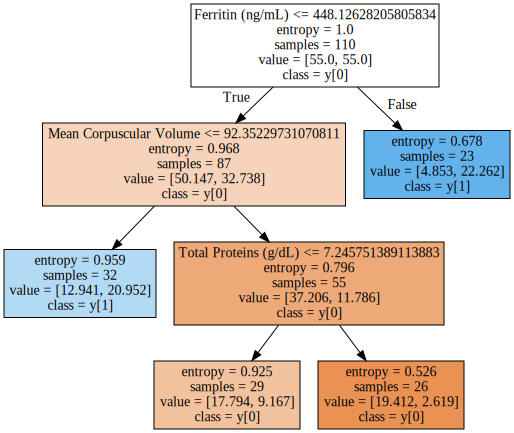

---------------------------------------
hcc-data_example- CV Dataset: 1
---------------------------------------


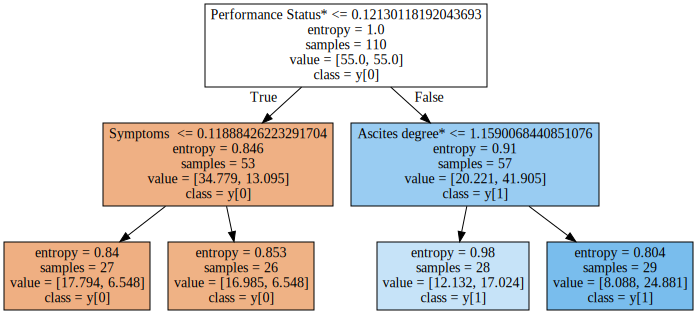

---------------------------------------
hcc-data_example- CV Dataset: 2
---------------------------------------


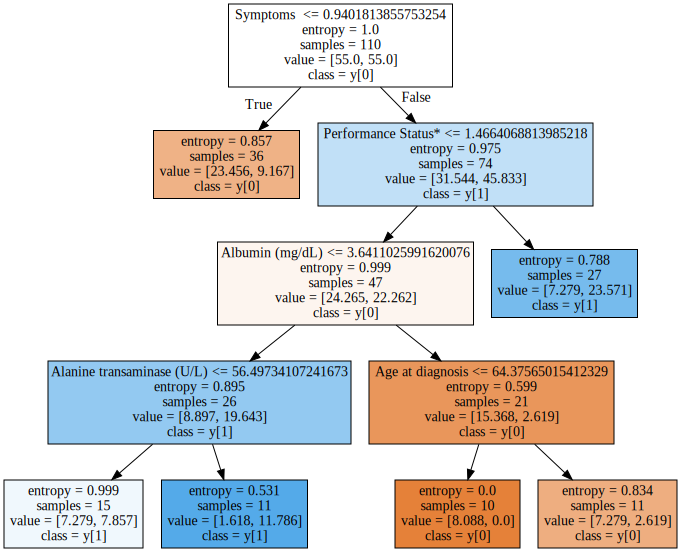

---------------------------------------
hcc-data_example_no_covariates- CV Dataset: 0
---------------------------------------


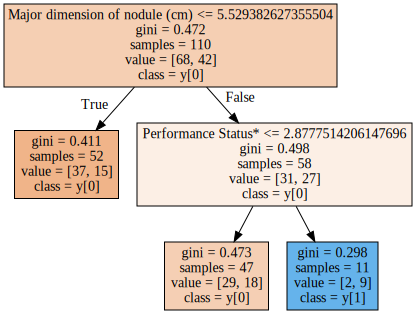

---------------------------------------
hcc-data_example_no_covariates- CV Dataset: 1
---------------------------------------


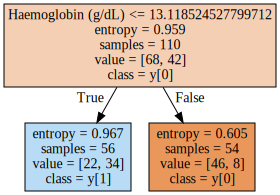

---------------------------------------
hcc-data_example_no_covariates- CV Dataset: 2
---------------------------------------


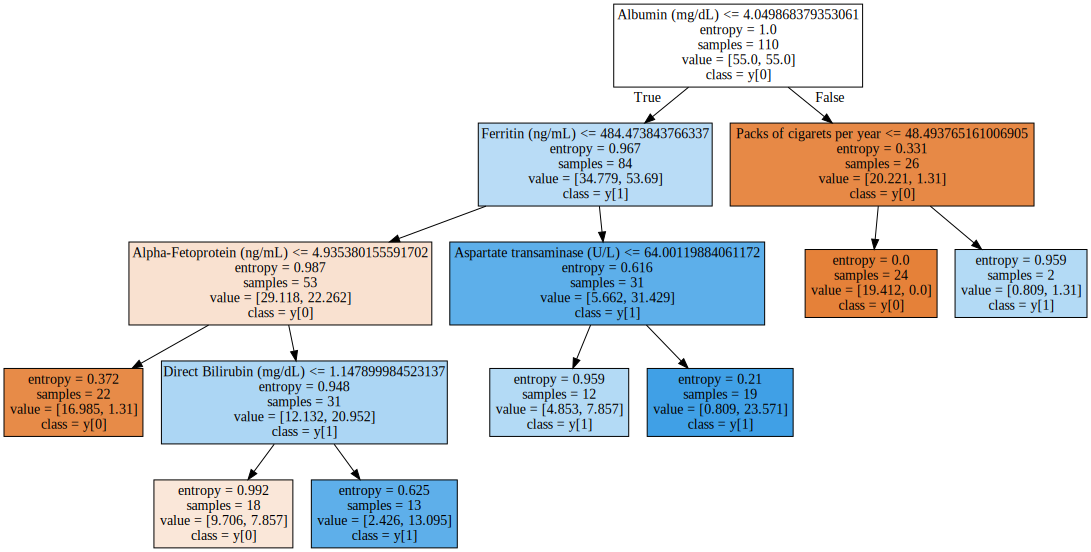

In [6]:
if not targetDataName == 'None': # User specified one analyzed dataset above (if more than one were analyzed)
    for each in datasets:
        if not each == targetDataName:
            datasets.remove(each)
    print("Vizualized Datasets: "+str(datasets))

#Unpickle metadata from previous phase
file = open(experiment_path+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
#Load variables specified earlier in the pipeline from metadata
class_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = metadata['CV Partitions']
scale_data = metadata['Use Data Scaling']

print("Number of CV Partitions: "+str(cv_partitions))
algorithm = 'DT' # Decision tree model identifier

for each in datasets: #each analyzed dataset to make plots for
    #Create folder for tree vizualization files
    if not os.path.exists(experiment_path+'/'+each+'/model_evaluation/DT_Viz'):
        os.mkdir(experiment_path+'/'+each+'/model_evaluation/DT_Viz')
        
    if bestOnly: # Identify best performing CV model to vizualize rather than all CV models
        #Open results dictionary to get metric for each CV
        cvMetrics = pd.read_csv(experiment_path+'/'+each+'/model_evaluation/DT_performance.csv',na_values='NA',sep=',')
        metric_cv_list = cvMetrics[targetMetric].tolist()
        #identify best CV
        max_value = max(metric_cv_list)
        max_index = metric_cv_list.index(max_value)
        # Vizualize best performing model
        print(str(targetMetric)+" values for each CV training set:")
        print(str(metric_cv_list))
        print("Best "+str(targetMetric)+": "+str(max_value))
        graph = generateTreePlot(experiment_path,each,algorithm,max_index,scale_data,class_label,instance_label,inverseScaling)
        print("---------------------------------------")
        print(each+"- CV Dataset: "+str(max_index))
        print("---------------------------------------")
        graph
    
    else: # Vizualize all CV models
        for cvCount in range(0,int(cv_partitions)):
            graph = generateTreePlot(experiment_path,each,algorithm,cvCount,scale_data,class_label,instance_label,inverseScaling)
            print("---------------------------------------")
            print(each+"- CV Dataset: "+str(cvCount))
            print("---------------------------------------")
            graph